# Cart-Pole Controller Assignment

This notebook consolidates the training and evaluation of various controllers for the cart-pole system, including Linear, Neural Network (NN), Mixture-of-Experts (MoE), and Hybrid controllers. The goal is to compare their performance in stabilizing the cart-pole system.

---

## Table of Contents
1. [Imports and Setup](#Imports-and-Setup)
2. [System Parameters and Utilities](#System-Parameters-and-Utilities)
3. [Linear Controller Only](#Linear-Controller-Only)
    - [3.1 Define System Parameters and Time Range](#31-Define-System-Parameters-and-Time-Range)
    - [3.2 Generate Initial Conditions](#32-Generate-Initial-Conditions)
    - [3.3 Train the Linear Controller](#33-Train-the-Linear-Controller)
    - [3.4 Plot Training Cost](#34-Plot-Training-Cost)
    - [3.5 Test the Trained Linear Controller](#35-Test-the-Trained-Linear-Controller)
    - [3.6 Implementing the LQR Controller](#36-Implementing-the-LQR-Controller)
    - [3.7 Compute Trajectory Costs for Comparison](#37-Compute-Trajectory-Costs-for-Comparison)
    - [3.8 Plot Trajectories for Comparison](#38-Plot-Trajectories-for-Comparison)
4. [Neural Network Controller Only](#Neural-Network-Controller-Only)
    - [4.1 Initialize and Train the Neural Network Controller](#41-Initialize-and-Train-the-Neural-Network-Controller)
    - [4.2 Simulate NN-Only Controller](#42-Simulate-NN-Only-Controller)
    - [4.3 Plot and Analyze Results](#43-Plot-and-Analyze-Results)
5. [Mixture-of-Experts (MoE) Controller](#Mixture-of-Experts-MoE-Controller)
    - [5.1 Initialize and Train the NN Controller](#51-Initialize-and-Train-the-NN-Controller)
    - [5.2 Setup the LQR Controller](#52-Setup-the-LQR-Controller)
    - [5.3 Initialize the Gating Network](#53-Initialize-the-Gating-Network)
    - [5.4 Initialize the MoE Controller](#54-Initialize-the-MoE-Controller)
    - [5.5 Simulate the Hybrid MoE Controller](#55-Simulate-the-Hybrid-MoE-Controller)
    - [5.6 Plot and Analyze Results](#56-Plot-and-Analyze-Results)
6. [Hybrid Controller](#Hybrid-Controller)
    - [6.1 Define Hybrid Controller](#61-Define-Hybrid-Controller)
    - [6.2 Train and Simulate Hybrid Controller](#62-Train-and-Simulate-Hybrid-Controller)
    - [6.3 Plot and Analyze Results](#63-Plot-and-Analyze-Results)


### 1. Imports and Setup

In [48]:
# Import necessary libraries
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

# Import project-specific modules
from diffrax import ODETerm, Tsit5, SaveAt, diffeqsolve
from controller.linear_controller import train_linear_controller
from controller.lqr_controller import linearize_cartpole, compute_lqr_gain
from controller.neuralnetwork_controller import MLP
from controller.moe_controller import GatingNetwork, DeterministicGating, MoEController
from controller.hybrid_controller import make_hybrid_controller
from env.closedloop import simulate_closed_loop
from env.cartpole import cartpole_dynamics_nn
from lib.trainer import train_nn_controller, adaptive_scaling, compute_energy
from Q3_main_moe import adaptive_scaling_fixed, compute_energy_fixed
from lib.utils import (
    plot_cost,
    sample_initial_conditions,
    plot_trajectory_comparison,
    plot_trajectory_comparison2,
    plot_cost_comparison,
    plot_control_forces_comparison,
    plot_trajectories,
    plot_theta_over_time,
    plot_energies,
    plot_combined_trajectories,
    compute_trajectory_cost,
    plot_trajectories3
)




### 2. System Parameters and Utilities

In [15]:
# Define system parameters for the cart-pole
mass_cart = 1.0      # Mass of the cart (m_c) in kg
mass_pole = 1.0      # Mass of the pole (m_p) in kg
pole_length = 1.0    # Length of the pole (l) in meters
gravity = 9.81       # Acceleration due to gravity (g) in m/s²

params = jnp.array([mass_cart, mass_pole, pole_length, gravity])

# Define simulation time settings
t_start = 0.0
t_end = 10.0
num_time_steps = 1001
t = jnp.linspace(t_start, t_end, num_time_steps)
t_span = (t_start, t_end)

### 3. Linear Controller Only
#### 3.1 Define System Parameters and Time Range
- Already defined in the previous section.
#### 3.2 Generate Initial Conditions

In [16]:
# Generate initial conditions for training the linear controller
initial_conditions_linear = sample_initial_conditions(
    num_samples=20,
    x_range=(-0.1, 0.1),
    theta_range=(-0.2, 0.2),
    xdot_range=(-0.2, 0.2),
    thetadot_range=(-0.2, 0.2),
    key=jr.PRNGKey(42)
)

#### 3.3 Train the Linear Controller

In [17]:
# Define the state cost matrix Q for the linear controller
Q_linear = jnp.diag(jnp.array([
    100.0,  # x position
    100.0,  # theta angle
    5.0,    # x velocity
    20.0    # theta angular velocity
]))

# Hyperparameters for linear controller optimization
linear_opt_hparams = {
    'lr': 0.0001,  # Learning rate
    'w_init': jnp.array([
        10.7477045,    # Weight for x
        -0.00142533379,   # Weight for cos(theta)
        -95.3456802,   # Weight for sin(theta)
        13.2174416,    # Weight for x_dot
        -27.8421364    # Weight for theta_dot
    ]),
    'max_iters': 3000,      # Maximum number of iterations
    'tolerance': 1e-6       # Convergence tolerance
}

print("\n=== Training Linear Controller ONLY ===")
linear_weights, linear_cost_history = train_linear_controller(
    params=params,
    t_span=t_span,
    t=t,
    initial_conditions=initial_conditions_linear,
    Q=Q_linear,
    opt_hyperparams=linear_opt_hparams
)


=== Training Linear Controller ONLY ===
Iteration 0, Cost: 24.094297, Weights: [ 1.0747604e+01 -1.5253330e-03 -9.5345581e+01  1.3217341e+01
 -2.7842236e+01]
Iteration 200, Cost: 24.092985, Weights: [ 1.0728426e+01 -2.7636378e-03 -9.5325745e+01  1.3199495e+01
 -2.7858725e+01]
Iteration 400, Cost: 24.092146, Weights: [ 1.0711098e+01 -2.6035239e-03 -9.5305908e+01  1.3186617e+01
 -2.7865213e+01]
Iteration 600, Cost: 24.091476, Weights: [ 1.06955338e+01 -2.48964923e-03 -9.52860718e+01  1.31772785e+01
 -2.78612309e+01]
Iteration 800, Cost: 24.090851, Weights: [ 1.0681603e+01 -2.4087850e-03 -9.5266235e+01  1.3169205e+01
 -2.7850349e+01]
Iteration 1000, Cost: 24.090242, Weights: [ 1.0669195e+01 -2.3486488e-03 -9.5246399e+01  1.3160976e+01
 -2.7836201e+01]
Iteration 1200, Cost: 24.089649, Weights: [ 1.0658209e+01 -2.3035591e-03 -9.5226562e+01  1.3152156e+01
 -2.7820448e+01]
Iteration 1400, Cost: 24.089062, Weights: [ 1.0648516e+01 -2.2705842e-03 -9.5206726e+01  1.3142789e+01
 -2.7803732e+01]
I

#### 3.4 Plot Training Cost

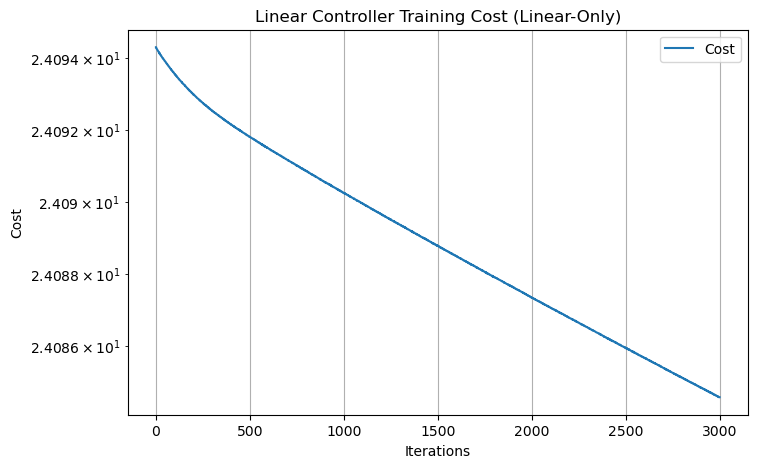

In [18]:
# Plot the training cost history for the linear controller
plot_cost(
    cost_history=linear_cost_history,
    title="Linear Controller Training Cost (Linear-Only)",
    log_scale=True
)

#### 3.5 Test the Trained Linear Controller

In [19]:
# Define a test initial condition
initial_condition_test_linear = jnp.array([-3.0, jnp.deg2rad(20), 2.0, -3.0])  # [x, theta, x_dot, theta_dot]

def linear_controller(state, time):
    x, theta, x_dot, theta_dot = state
    control = (
        linear_weights[0] * x +
        linear_weights[1] * jnp.cos(theta) +
        linear_weights[2] * jnp.sin(theta) +
        linear_weights[3] * x_dot +
        linear_weights[4] * theta_dot
    )
    return control

# Simulate closed-loop system with the linear controller
solution_linear = simulate_closed_loop(
    controller=linear_controller,
    params=params,
    t_span=t_span,
    t=t,
    initial_state=initial_condition_test_linear
)

states_linear = solution_linear.ys

#### 3.6 Implementing the LQR Controller

In [20]:
# Define LQR cost matrices
Q_lqr = Q_linear  # State cost matrix
R_lqr = jnp.array([[0.1]])  # Control effort cost

# Linearize the cart-pole system around the equilibrium
A_linear, B_linear = linearize_cartpole(params)

# Compute the LQR gain matrix K
K_lqr = compute_lqr_gain(A_linear, B_linear, Q_lqr, R_lqr)

def lqr_controller(state, time):
    control = -(K_lqr @ state)[0]
    return control

# Simulate closed-loop system with the LQR controller
solution_lqr = simulate_closed_loop(
    controller=lqr_controller,
    params=params,
    t_span=t_span,
    t=t,
    initial_state=initial_condition_test_linear
)

states_lqr = solution_lqr.ys

#### 3.7 Compute Trajectory Costs for Comparison

In [21]:
# Compute trajectory costs for both controllers
linear_cost, linear_control_forces = compute_trajectory_cost(
    Q=Q_linear,
    states=states_linear,
    controller_func=linear_controller,
    t=t
)

lqr_cost, lqr_control_forces = compute_trajectory_cost(
    Q=Q_linear,
    states=states_lqr,
    controller_func=lqr_controller,
    t=t
)

print("\nTrained Linear Weights:", linear_weights)
print("Final cost (trained linear):", linear_cost)
print("Final cost (LQR):", lqr_cost)


Trained Linear Weights: [ 1.0598432e+01 -2.2360538e-03 -9.5048134e+01  1.3063215e+01
 -2.7661816e+01]
Final cost (trained linear): 550.46436
Final cost (LQR): 642.61523


#### 3.8 Plot Trajectories for Comparison

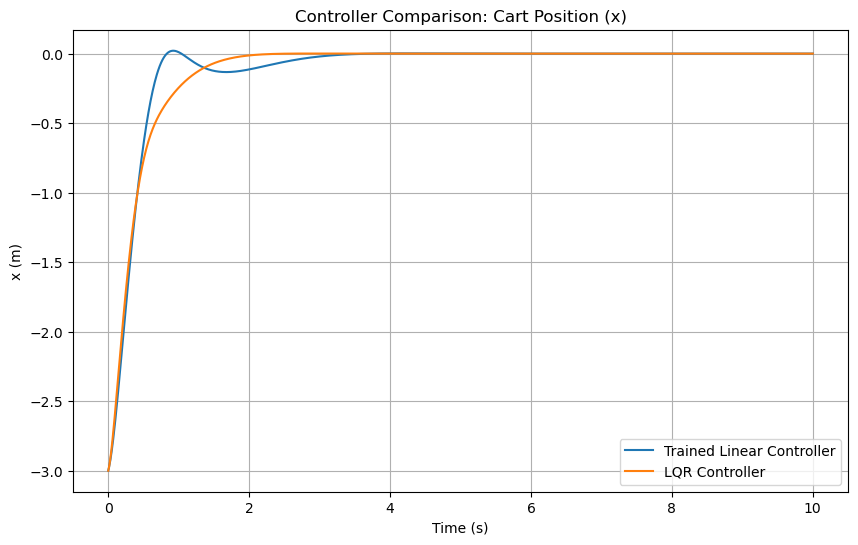

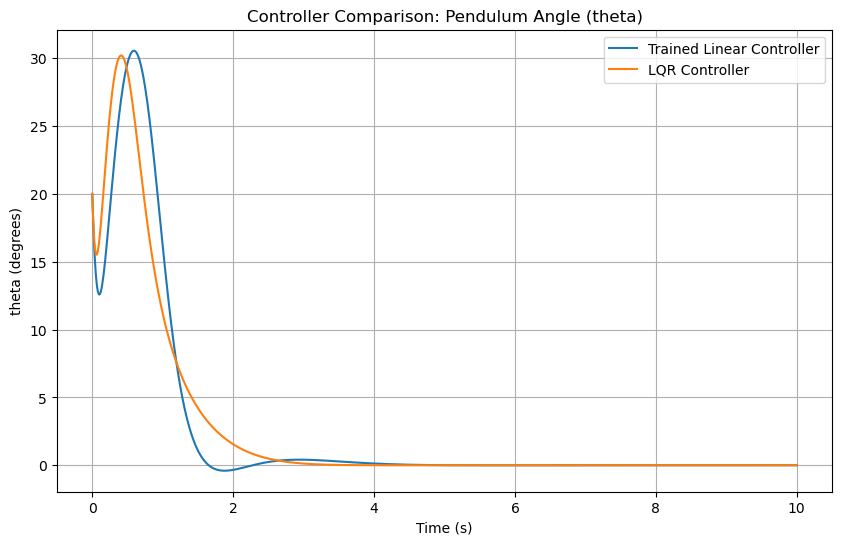

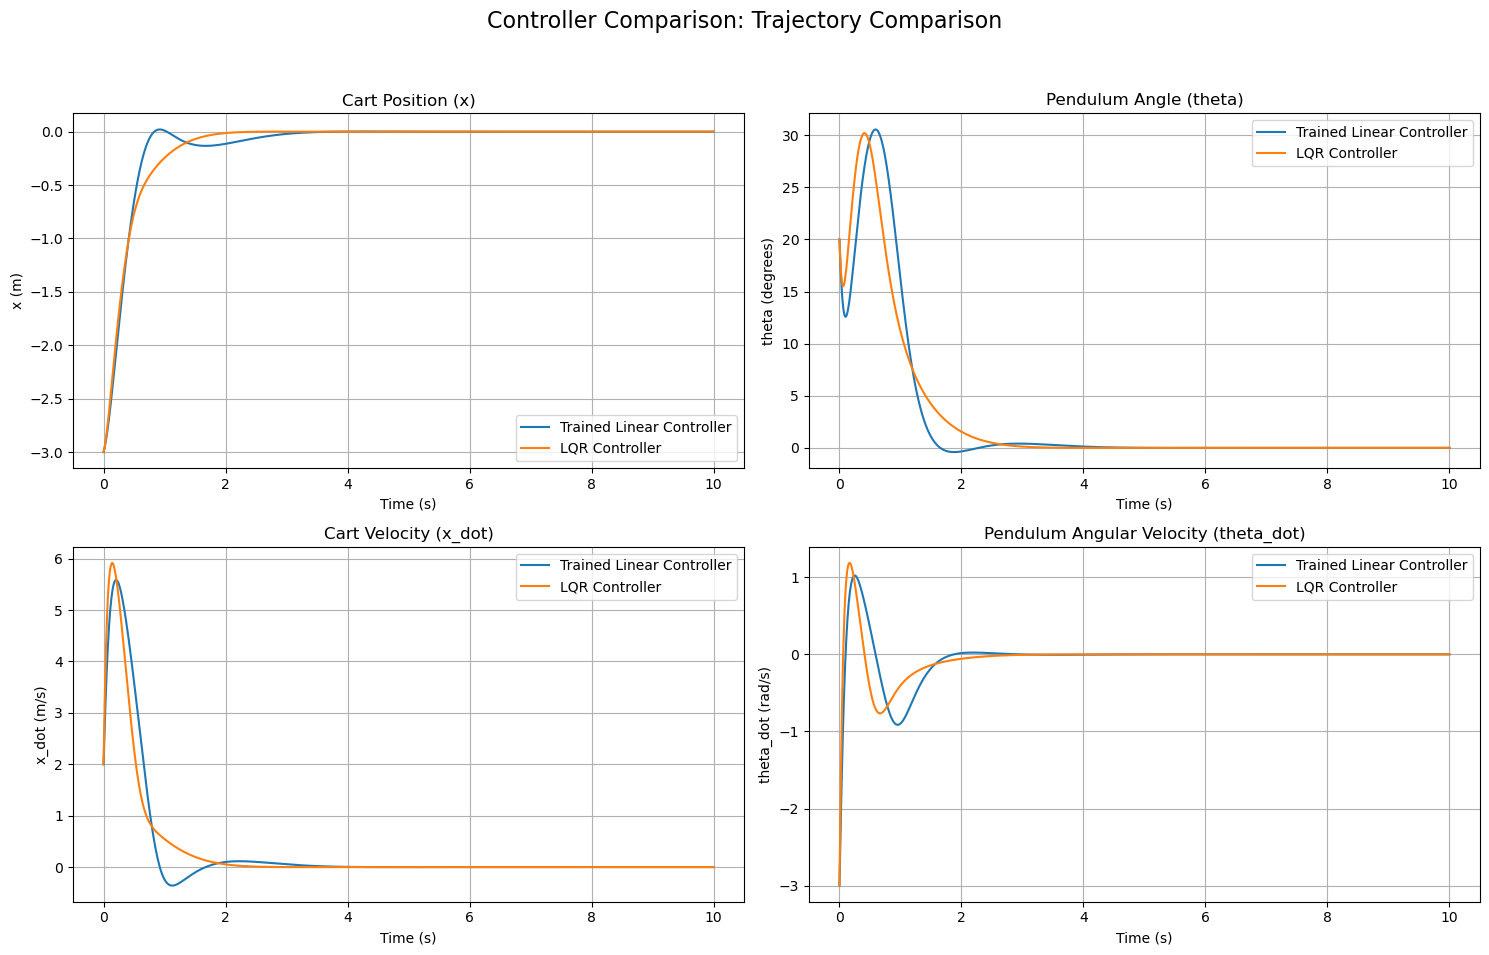

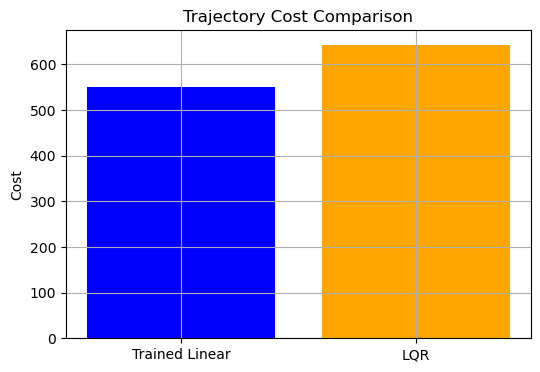

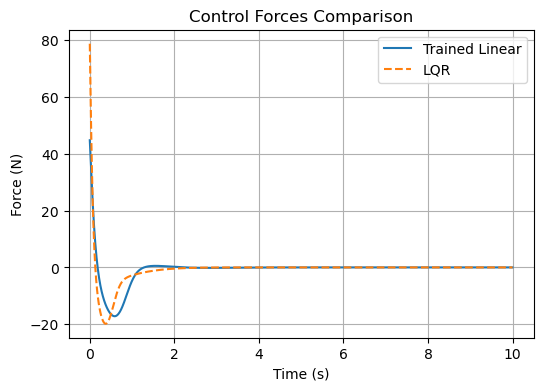

In [22]:
# Prepare list of state trajectories and labels
states_list = [states_linear, states_lqr]
labels = ["Trained Linear Controller", "LQR Controller"]

# Plot trajectory comparisons
plot_trajectory_comparison(
    t=t,
    states_list=states_list,
    labels=labels,
    title_prefix="Controller Comparison"
)

plot_trajectory_comparison2(
    t=t,
    states_list=states_list,
    labels=labels,
    title_prefix="Controller Comparison"
)

# Plot cost comparison
plot_cost_comparison(
    linear_cost=linear_cost,
    lqr_cost=lqr_cost,
    title="Trajectory Cost Comparison"
)

# Plot control forces comparison
plot_control_forces_comparison(
    t=t,
    linear_forces=linear_control_forces,
    lqr_forces=lqr_control_forces,
    title="Control Forces Comparison"
)

### 4. Neural Network Controller Only
#### 4.1 Initialize and Train the Neural Network Controller


=== Training the Neural Network Controller ===
Iteration 0: Cost = 554.724304 | Elapsed Time: 8.54 s
Iteration 50: Cost = 720.705261 | Elapsed Time: 33.51 s
Iteration 100: Cost = 819.503906 | Elapsed Time: 57.56 s
Iteration 150: Cost = 1932.185913 | Elapsed Time: 81.93 s
Iteration 200: Cost = 729.658508 | Elapsed Time: 105.69 s
Iteration 250: Cost = 1583.045288 | Elapsed Time: 129.18 s
Iteration 300: Cost = 728.686951 | Elapsed Time: 152.78 s
Iteration 350: Cost = 564.683838 | Elapsed Time: 176.43 s
Iteration 400: Cost = 1496.502930 | Elapsed Time: 200.34 s
Iteration 450: Cost = 1009.244568 | Elapsed Time: 224.16 s
Iteration 500: Cost = 87.204285 | Elapsed Time: 248.01 s
Iteration 550: Cost = 1404.730225 | Elapsed Time: 271.94 s
Iteration 600: Cost = 1043.052734 | Elapsed Time: 295.81 s
Iteration 650: Cost = 1996.936035 | Elapsed Time: 319.91 s
Iteration 700: Cost = 678.172363 | Elapsed Time: 344.03 s
Iteration 750: Cost = 1223.111694 | Elapsed Time: 367.77 s
Iteration 800: Cost = 994

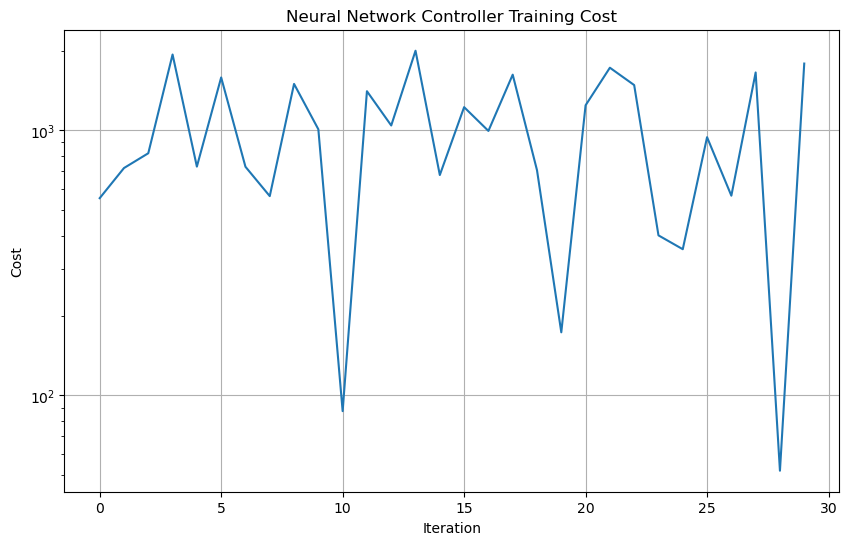

In [23]:
# Initialize the Neural Network controller
key_nn = jr.PRNGKey(0)
nn_model = MLP(
    in_size=5,         # [x, sin(theta), cos(theta), x_dot, theta_dot]
    hidden_sizes=[64, 64],
    out_size=1,
    key=key_nn
)

print("\n=== Training the Neural Network Controller ===")
num_iterations_nn = 1500
learning_rate_nn = 1e-3
dt_nn = 0.001
simulation_time_nn = 10.0

trained_model, cost_history_nn = train_nn_controller(
    env_params=params,
    model=nn_model,
    num_iterations=num_iterations_nn,
    learning_rate=learning_rate_nn,
    dt=dt_nn,
    T=simulation_time_nn
)

print("NN Training Complete!")

# Plot training cost
plt.figure(figsize=(10, 6))
plt.plot(cost_history_nn)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Neural Network Controller Training Cost')
plt.yscale('log')
plt.grid(True)
plt.show()

#### 4.2 Simulate NN-Only Controller

In [46]:

# Cart-pole system parameters
mass_cart = 1.0      # Mass of the cart (m_c) in kg
mass_pole = 0.2      # Mass of the pole (m_p) in kg
pole_length = 0.5    # Length of the pole (l) in meters
gravity = 9.81       # Acceleration due to gravity (g) in m/s²
env_params = (mass_cart, mass_pole, pole_length, gravity)

desired_energy = 2.0 * mass_pole * gravity * pole_length


# Initial state: x cos(theta) sin(theta) x_dot theta_dot
initial_state = jnp.array([0.0, -1.0, 0.0, 0.0, 0.0])

def force_function(t, state):
    """
    Compute the control force at a given time and state.

    Parameters:
    ----------
    t : float
        Current time.
    state : array-like
        Current state of the system.

    Returns:
    -------
    float
        Control force to be applied.
    """
    # Compute the adaptive scaling factor based on the current state
    scaling_factor = adaptive_scaling(
        state,
        mass_cart,
        mass_pole,
        pole_length,
        gravity,
        desired_energy
    )
    

    # Compute the raw force from the trained model
    raw_force = trained_model(state)
    
    # Scale the force appropriately
    force = 15 * scaling_factor * raw_force  
    
    return force


# -----------------------------------------------------------------------
# 6. Set Up and Solve the Differential Equation
# -----------------------------------------------------------------------

# Define the ODE term using the cart-pole cartpole_dynamics_nn
ode_term = ODETerm(cartpole_dynamics_nn)

# Choose the ODE solver (Tsit5 is a 5th-order Runge-Kutta method)
solver = Tsit5()

# Simulation time settings
t_start = 0.0
t_end = 10.0
num_time_steps = 1001
time_points = jnp.linspace(t_start, t_end, num_time_steps)

# Solve the ODE using diffeqsolve
solution = diffeqsolve(
    ode_term,
    solver,
    t0=t_start,
    t1=t_end,
    dt0=0.001,
    y0=initial_state,
    args=(env_params, force_function),
    saveat=SaveAt(ts=time_points),
    max_steps=50_000
)

states_nn = solution.ys

#### 4.3 Plot and Analyze Results

Plotting the trajectories...


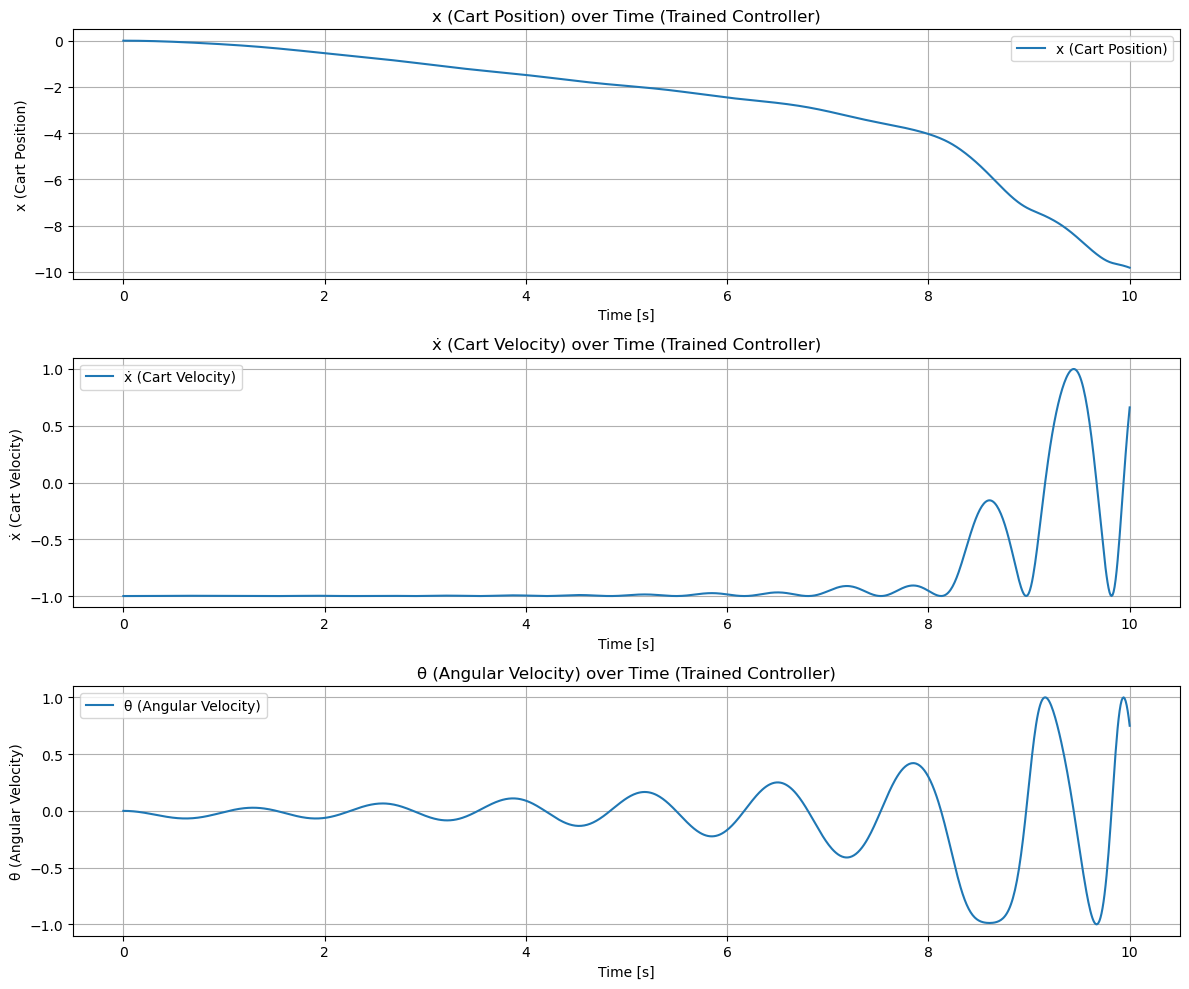

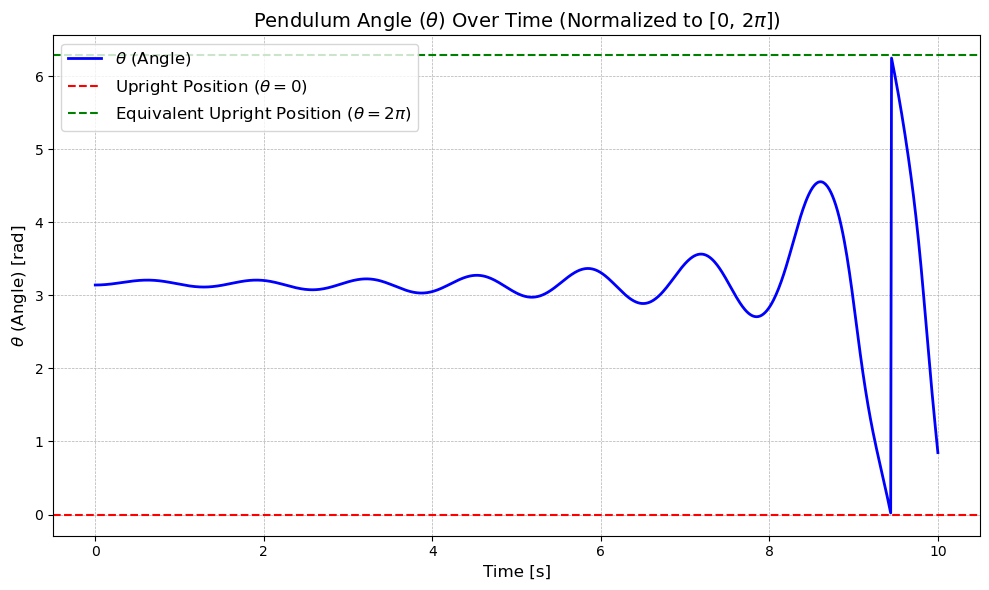

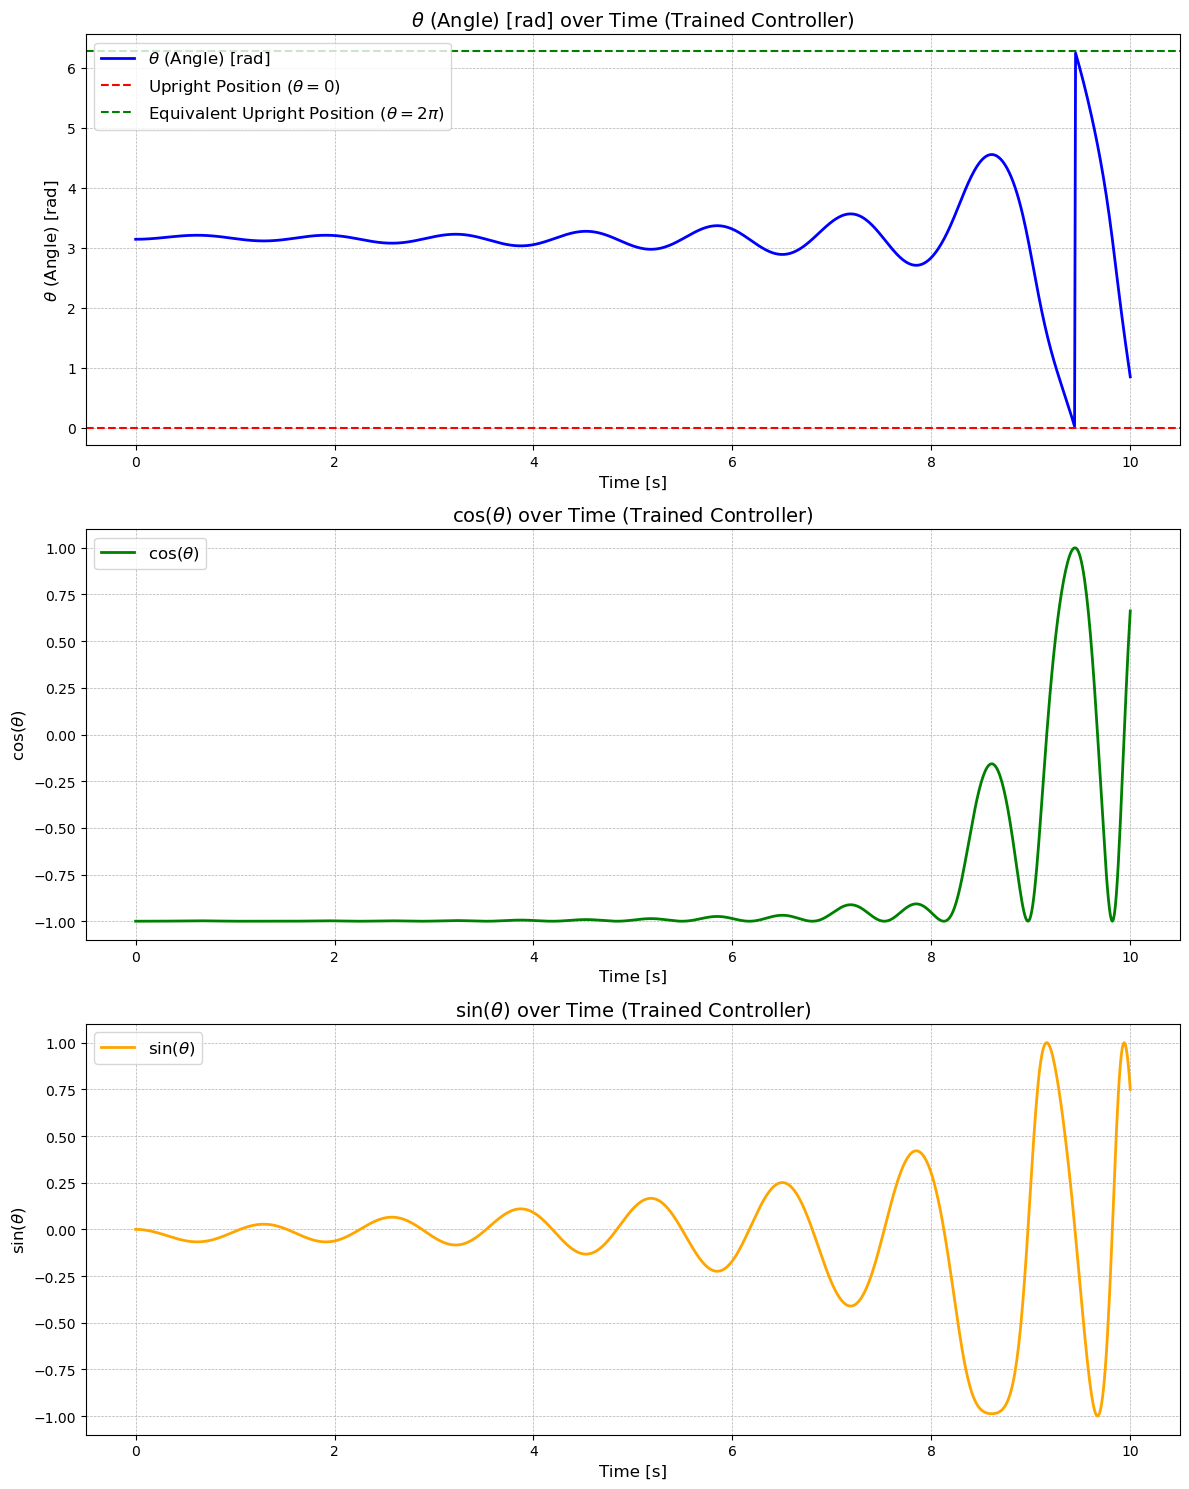

In [54]:

print("Plotting the trajectories...")

plot_trajectories3(
    solution.ts,
    solution.ys,
    "(Trained Controller)"
)

# -----------------------------------------------------------------------
# 8. Analyze and Plot Energy and Angle Over Time
# -----------------------------------------------------------------------

# Extract theta (angle) from simulation results
sin_theta = solution.ys[:, 2]  # Assuming state[2] corresponds to sin(theta)
cos_theta = solution.ys[:, 1]  # Assuming state[1] corresponds to cos(theta)
theta_values = jax.vmap(jnp.arctan2)(sin_theta, cos_theta)

# Normalize theta to the range [0, 2π]
theta_normalized = jnp.mod(theta_values, 2 * jnp.pi)

# Compute initial potential energy
initial_potential_energy = mass_pole * gravity * pole_length * (1 - cos_theta[0])
#print(f"Initial potential energy: {initial_potential_energy:.2f} J")
#print(f"Desired energy: {desired_energy:.2f} J")

# Compute total, kinetic, and potential energies over time
energies, kinetic_energies, potential_energies = jax.vmap(
    compute_energy,
    in_axes=(0, None, None, None, None)
)(solution.ys, mass_cart, mass_pole, pole_length, gravity)

# Plot Pendulum Angle Over Time
plot_theta_over_time(
    solution.ts,
    theta_normalized
)


# Convert JAX arrays to NumPy arrays for plotting (if necessary)
traj = jnp.stack([theta_normalized, cos_theta, sin_theta], axis=1)  # Shape: (N, 3)
traj_np = jnp.array(traj)
t_np = jnp.array(solution.ts)

# Plot Combined Trajectories using the merged function
plot_combined_trajectories(
    t_np,
    traj_np,
    title_suffix="(Trained Controller)"
)

### 5. Mixture-of-Experts (MoE) Controller
#### 5.1 Initialize and Train the NN Controller (trained in the previous section)
#### 5.2 Setup the LQR Controller

In [50]:
# Setup LQR Controller
print("\n=== Setting up the LQR Controller for MoE ===")
A_moe, B_moe = linearize_cartpole(params)
Q_lqr_moe = jnp.diag(jnp.array([50.0, 50.0, 5.0, 10.0]))
R_lqr_moe = jnp.array([[0.1]])
K_lqr_moe = compute_lqr_gain(A_moe, B_moe, Q_lqr_moe, R_lqr_moe)

def lqr_controller_moe(state, t):
    return -(K_lqr_moe @ state)[0]


=== Setting up the LQR Controller for MoE ===


#### 5.3 Initialize the Gating Network

In [55]:
# Initialize the Gating Network
gating_key = jr.PRNGKey(1)
gating_net_moe = GatingNetwork(
    in_dim=4,       # [x, theta, x_dot, theta_dot]
    num_experts=2,
    key=gating_key,
    temperature=0.3
)

#### 5.4 Initialize the MoE Controller

In [58]:
# Define the NN Controller for MoE
def nn_controller_moe(state, t):
    scaling_factor = adaptive_scaling_fixed(
        state, mass_cart, mass_pole, pole_length, gravity, desired_energy
    )
    raw_force = trained_model(jnp.array([
        state[0],
        jnp.sin(state[1]),
        jnp.cos(state[1]),
        state[2],
        state[3]
    ]))
    force = 10.0 * scaling_factor * raw_force
    return force

# Initialize the MoE Controller with NN and LQR experts
moe_controller = MoEController(
    gating=gating_net_moe,
    experts=[nn_controller_moe, lqr_controller_moe]
)

#### 5.5 Simulate the Hybrid MoE Controller

In [59]:
# Define simulation parameters for MoE
t_start_moe = 0.0
t_end_moe = 14.0
num_time_steps_moe = 1401
t_eval_moe = jnp.linspace(t_start_moe, t_end_moe, num_time_steps_moe)
t_span_moe = (t_start_moe, t_end_moe)

# Define initial state for MoE simulation
initial_state_moe = jnp.array([0.0, jnp.pi, 0.0, 0.0])  # [x, theta, x_dot, theta_dot]

# Simulate closed-loop system using the MoE controller
solution_moe = simulate_closed_loop(
    controller=moe_controller,
    params=params,
    t_span=t_span_moe,
    t=t_eval_moe,
    initial_state=initial_state_moe
)

states_moe = solution_moe.ys

#### 5.6 Plot and Analyze Results


=== Plotting MoE Controller Trajectories ===


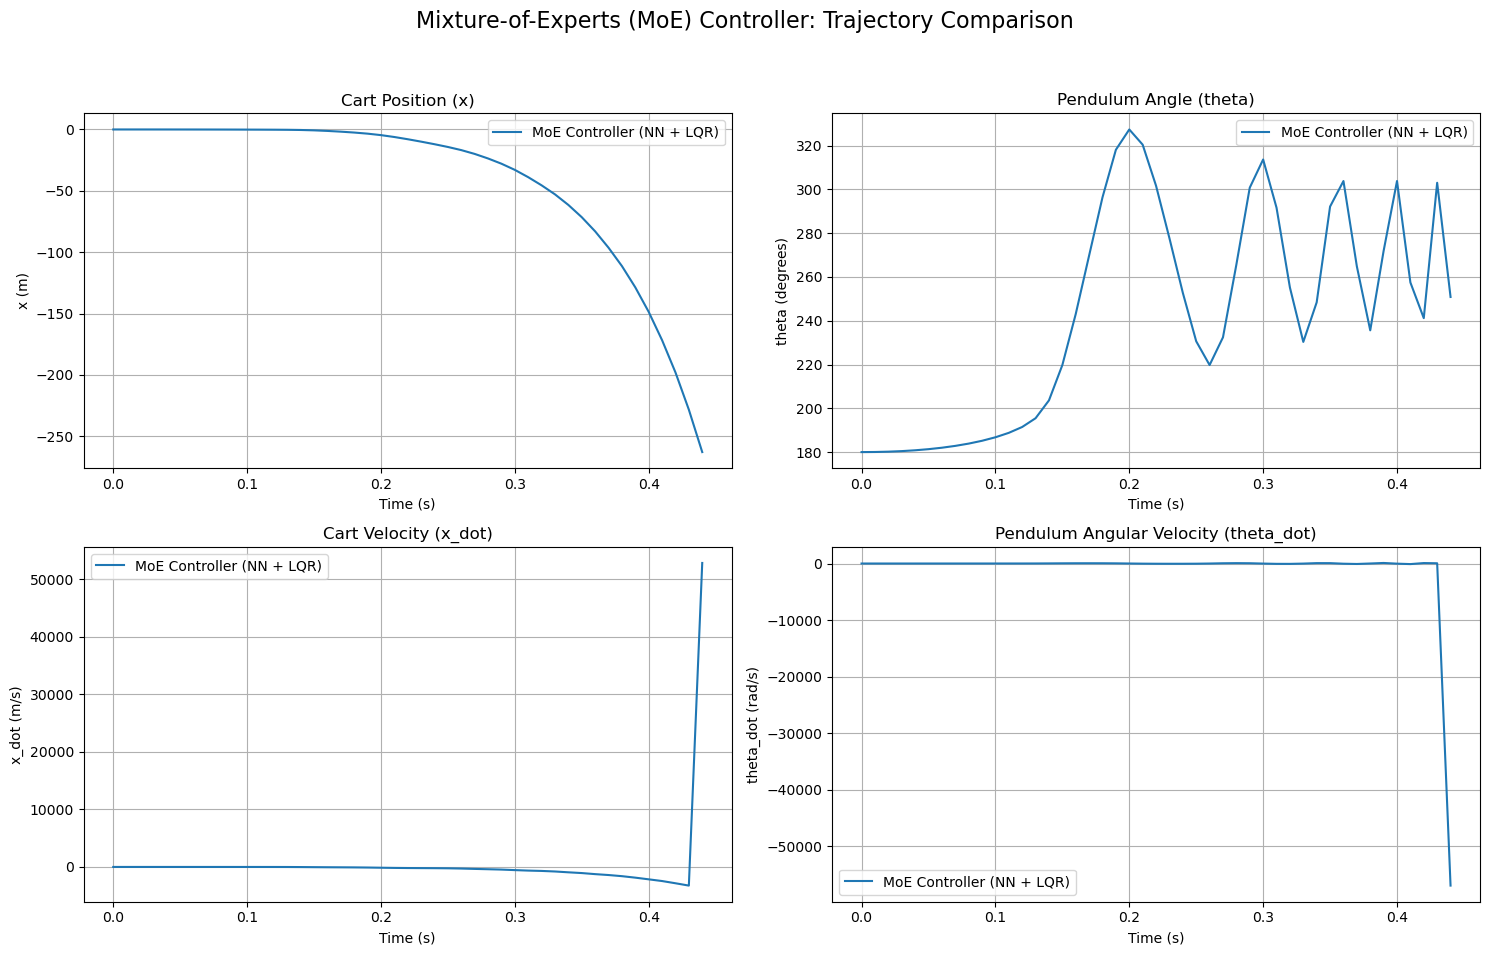

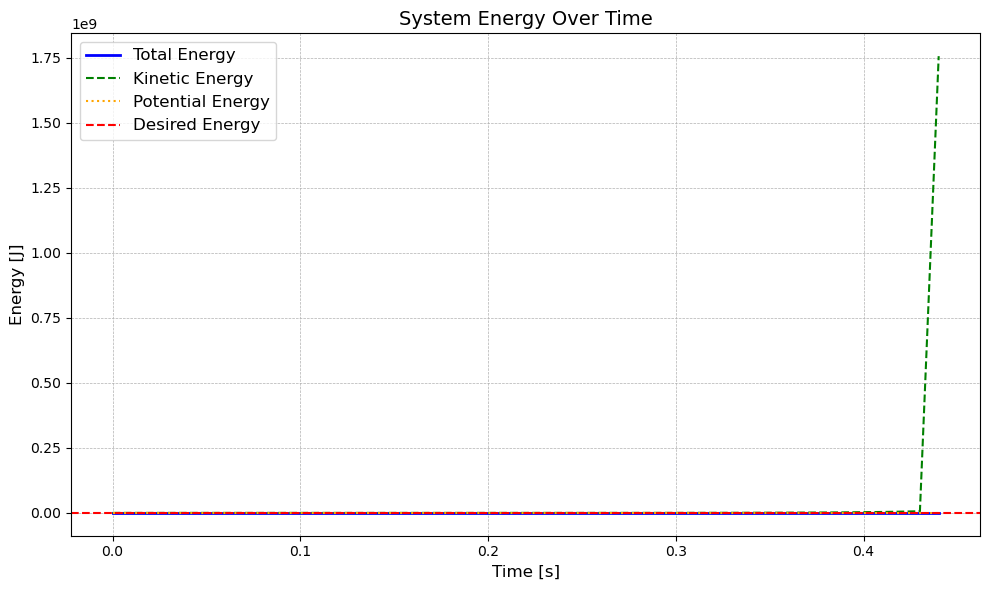

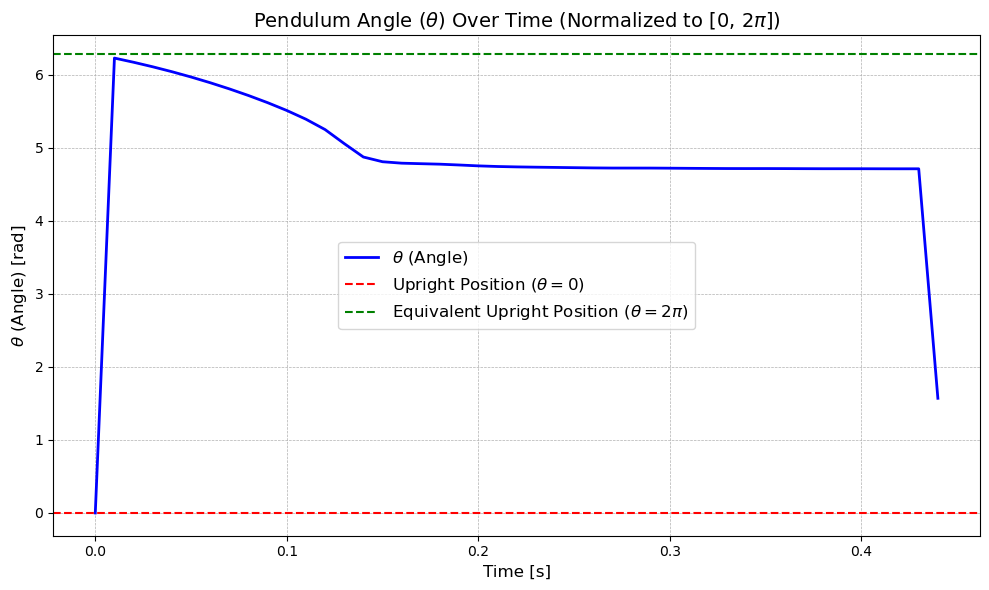

In [60]:
# Plot trajectory comparison for MoE
print("\n=== Plotting MoE Controller Trajectories ===")
plot_trajectory_comparison2(
    t=t_eval_moe,
    states_list=[states_moe],
    labels=["MoE Controller (NN + LQR)"],
    title_prefix="Mixture-of-Experts (MoE) Controller"
)

# Compute energies over time for MoE
energies_moe, kinetic_energies_moe, potential_energies_moe = jax.vmap(
    compute_energy_fixed,
    in_axes=(0, None, None, None, None)
)(states_moe, mass_cart, mass_pole, pole_length, gravity)

# Plot energies
plot_energies(
    solution_moe.ts,
    energies_moe,
    kinetic_energies_moe,
    potential_energies_moe,
    desired_energy
)

# Plot pendulum angle over time for MoE
theta_values_moe = jnp.arctan2(states_moe[:, 2], states_moe[:, 1])
theta_normalized_moe = jnp.mod(theta_values_moe, 2 * jnp.pi)

plot_theta_over_time(
    solution_moe.ts,
    theta_normalized_moe
)

### 6. Hybrid Controller
#### 6.1 Define Hybrid Controller

In [74]:
key = jr.PRNGKey(0)
nn_model = MLP(
    in_size=5,         # [x, sin(theta), cos(theta), x_dot, theta_dot]
    hidden_sizes=[64, 64],
    out_size=1,
    key=key
)

print("\n=== Training the Neural Network Controller ===")
num_iterations = 100 # Increased training iterations
learning_rate = 1e-3
dt = 0.001
simulation_time = 10.0

trained_model, cost_history = train_nn_controller(
    env_params=env_params,
    model=nn_model,
    num_iterations=num_iterations,
    learning_rate=learning_rate,
    dt=dt,
    T=simulation_time
)
print("NN Training Complete!")


=== Training the Neural Network Controller ===
Iteration 0: Cost = 19050.896484 | Elapsed Time: 9.39 s
Iteration 50: Cost = 29517.949219 | Elapsed Time: 33.64 s
NN Training Complete!


#### 6.2 Train and Simulate Hybrid Controller

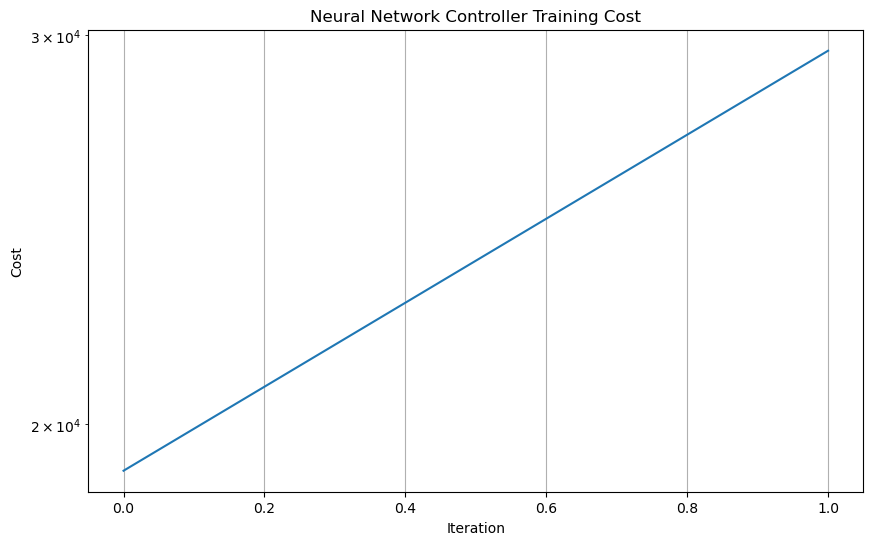


=== Setting up the LQR Controller ===

=== Initializing the Gating Network ===


In [75]:
# Plot training cost if desired
plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Neural Network Controller Training Cost')
plt.yscale('log')
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------
# C. Setup the LQR Controller
# -----------------------------------------------------------------------
print("\n=== Setting up the LQR Controller ===")
A, B = linearize_cartpole(jnp.array(env_params))
Q_lqr = jnp.diag(jnp.array([50.0, 50.0, 5.0, 10.0]))
R_lqr = jnp.array([[0.1]])
K = compute_lqr_gain(A, B, Q_lqr, R_lqr)  # Shape: (1,4)

def lqr_controller(state: jnp.ndarray, t: float) -> float:
    """
    LQR controller function.

    Args:
        state (jnp.ndarray): Current state [x, theta, x_dot, theta_dot].
        t (float): Current time.

    Returns:
        float: Control force.
    """
    return -(K @ state)[0]

# -----------------------------------------------------------------------
# D. Initialize the Gating Network
# -----------------------------------------------------------------------
print("\n=== Initializing the Gating Network ===")

#### 6.3 Plot and Analyze Results

In [76]:
gating_key = jr.PRNGKey(0)
gating_net = GatingNetwork(in_dim=4, num_experts=2, key=gating_key, temperature=0.3)

In [77]:
def nn_controller_fixed(state: jnp.ndarray, t: float) -> float:
    """
    Neural Network controller function using fixed adaptive scaling.

    Args:
        state (jnp.ndarray): Current state [x, theta, x_dot, theta_dot].
        t (float): Current time.

    Returns:
        float: Control force.
    """
    x, theta, x_dot, theta_dot = state
    # Construct a 5-element state: [x, cos(theta), sin(theta), x_dot, theta_dot]
    state_5 = jnp.array([
        x,
        jnp.cos(theta),
        jnp.sin(theta),
        x_dot,
        theta_dot
    ])
    raw_force = trained_model(state_5)
    # Compute desired energy
    desired_energy = 2.0 * mass_pole * gravity * pole_length
    # Apply adaptive scaling using the fixed function
    scaling_factor = adaptive_scaling_fixed(
        state,  # Pass the 4-element state
        mass_cart,
        mass_pole,
        pole_length,
        gravity,
        desired_energy
    )
    # Scale the force appropriately (adjust the scaling factor as needed)
    force = 10.0 * scaling_factor * raw_force  # Adjusted scaling factor
    return force

In [78]:
# Define the LQR controller as an expert
def lqr_ctrl(state: jnp.ndarray, t: float) -> float:
    return lqr_controller(state, t)

# Create the MoE controller with NN and LQR experts
moe_controller = MoEController(
    gating=gating_net,
    experts=[nn_controller_fixed, lqr_ctrl]
)

In [79]:
print("\n=== Simulating the Hybrid MoE Controller ===")
# Define simulation parameters
t_start = 0.0
t_end = 14.0  # Extended simulation time
num_time_steps = 1401  # Increased number of time steps for higher resolution
t_eval = jnp.linspace(t_start, t_end, num_time_steps)
t_span = (t_start, t_end)

# Define initial conditions for simulation
initial_state_hybrid = jnp.array([0.0, jnp.pi, 0.0, 0.0])  # [x, theta, x_dot, theta_dot]

# Simulate closed-loop system using the MoE controller
solution_moe = simulate_closed_loop(
    controller=moe_controller,
    params=jnp.array(env_params),
    t_span=t_span,
    t=t_eval,
    initial_state=initial_state_hybrid
)

states_moe = solution_moe.ys  # Shape: (len(t_eval), 4)


=== Simulating the Hybrid MoE Controller ===



=== Plotting the Hybrid MoE Controller Results ===
Final State (Hybrid MoE): [nan nan nan nan]


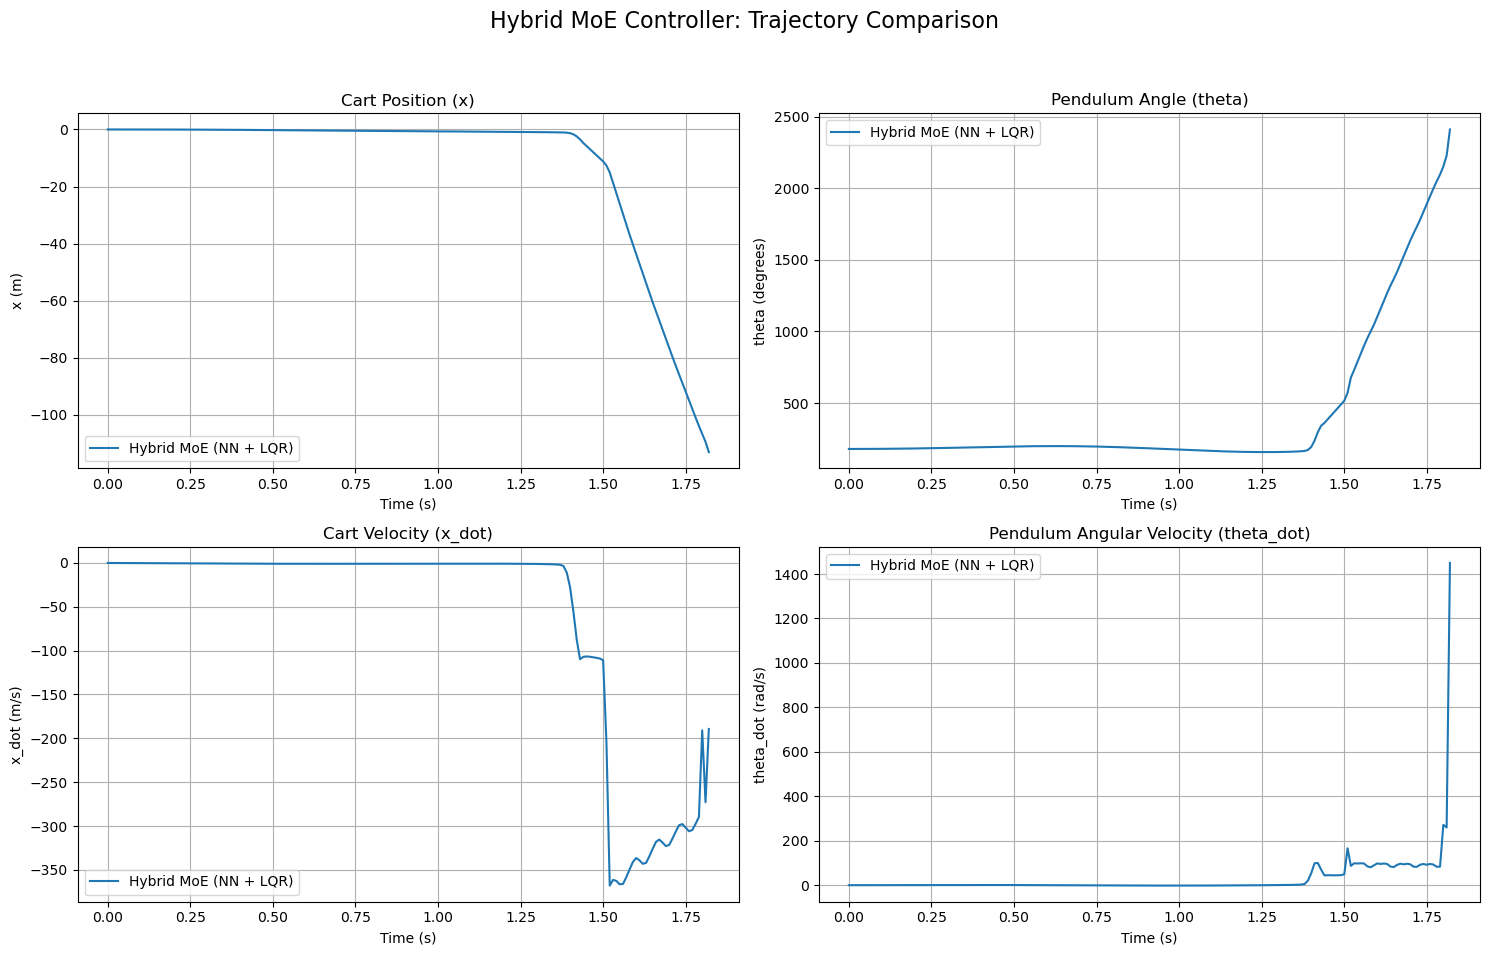

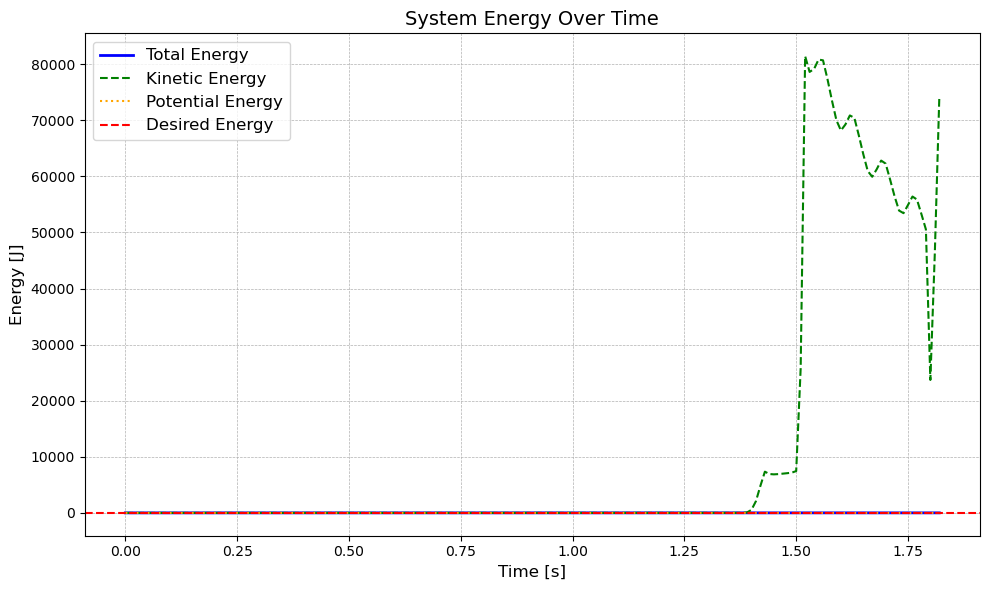

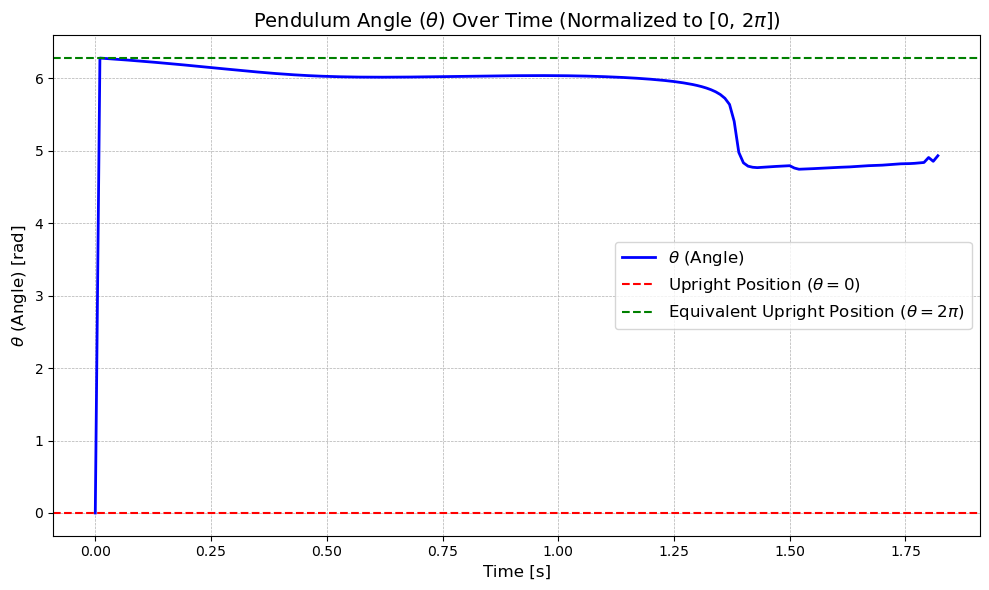


=== Simulation Complete! ===


In [80]:
print("\n=== Plotting the Hybrid MoE Controller Results ===")
print("Final State (Hybrid MoE):", states_moe[-1, :])

# Plot trajectory comparison
plot_trajectory_comparison2(
    t_eval,
    [states_moe],
    labels=["Hybrid MoE (NN + LQR)"],
    title_prefix="Hybrid MoE Controller"
)

# Plot energies over time using the fixed compute_energy function
energies, kinetic_energies, potential_energies = jax.vmap(
    compute_energy_fixed,  # Use the fixed function
    in_axes=(0, None, None, None, None)
)(states_moe, mass_cart, mass_pole, pole_length, gravity)

desired_energy = 2.0 * mass_pole * gravity * pole_length

plot_energies(
    solution_moe.ts,
    energies,
    kinetic_energies,
    potential_energies,
    desired_energy
)

# Plot pendulum angle over time
theta_values = jnp.arctan2(states_moe[:, 2], states_moe[:, 1])  # tan(theta) = sin(theta)/cos(theta)
theta_normalized = jnp.mod(theta_values, 2 * jnp.pi)

plot_theta_over_time(
    solution_moe.ts,
    theta_normalized
)

print("\n=== Simulation Complete! ===")